In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# List of seed numbers you want to loop over
seed_numbers = range(0, 8)  # Adjust this range as needed
particle_num_list = [30, 100, 300, 1000]
I_err = {'iid': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'mmd_flow': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'kernel_herding': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))]}

for e, particle_num in enumerate(particle_num_list):
    for seed in seed_numbers:
        dir_path = f"/home/zongchen/mmd_flow_cubature/results/mmd_flow/mog_dataset/Gaussian_kernel/"
        dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_10000__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}/"
        I_err['iid'][0][e, seed] = np.load(dir_path + 'iid_err.npy')
        I_err['mmd_flow'][0][e, seed] = np.load(dir_path + 'mmd_flow_err.npy')
        I_err['iid'][1][e, seed] = np.load(dir_path + 'mmd_flow_err.npy')
        I_err['mmd_flow'][1][e, seed] = np.load(dir_path + 'mmd_flow_err.npy')

        dir_path = f"/home/zongchen/mmd_flow_cubature/results/kernel_herding/mog_dataset/Gaussian_kernel/"
        dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_10000__particle_num_{particle_num}__seed_{seed}/"

        I_err['kernel_herding'][0][e, seed] = np.load(dir_path + 'kh_err.npy')
        I_err['kernel_herding'][1][e, seed] = np.load(dir_path + 'kh_err.npy')


In [3]:
I_err['iid'][0] = np.nanmean(I_err['iid'][0], axis=1)
I_err['iid'][1] = np.nanstd(I_err['iid'][1], axis=1) / np.sqrt(I_err['iid'][1].shape[1])
I_err['mmd_flow'][0] = np.nanmean(I_err['mmd_flow'][0], axis=1)
I_err['mmd_flow'][1] = np.nanstd(I_err['mmd_flow'][1], axis=1) / np.sqrt(I_err['mmd_flow'][1].shape[1])
I_err['kernel_herding'][0] = np.nanmean(I_err['kernel_herding'][0], axis=1)
I_err['kernel_herding'][1] = np.nanstd(I_err['kernel_herding'][1], axis=1) / np.sqrt(I_err['kernel_herding'][1].shape[1])

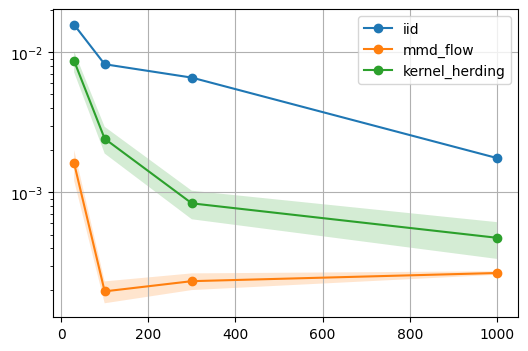

In [4]:
fig1 = plt.figure(figsize=(6, 4))
plt.grid(True)

plt.plot(particle_num_list, I_err['iid'][0], label='iid', marker='o')
plt.fill_between(particle_num_list, I_err['iid'][0] - I_err['iid'][1], I_err['iid'][0] + I_err['iid'][1], alpha=0.2)
plt.plot(particle_num_list, I_err['mmd_flow'][0], label='mmd_flow', marker='o')
plt.fill_between(particle_num_list, I_err['mmd_flow'][0] - I_err['mmd_flow'][1], I_err['mmd_flow'][0] + I_err['mmd_flow'][1], alpha=0.2)
plt.plot(particle_num_list, I_err['kernel_herding'][0], label='kernel_herding', marker='o')
plt.fill_between(particle_num_list, I_err['kernel_herding'][0] - I_err['kernel_herding'][1], I_err['kernel_herding'][0] + I_err['kernel_herding'][1], alpha=0.2)
plt.yscale('log')
plt.legend()
plt.show()